# Entrono #

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [3]:
# ----------------------------
# Pub/Sub Broker
# ----------------------------
class PubSubBroker:
    def __init__(self):
        self.subscribers = []

    def subscribe(self, callback):
        self.subscribers.append(callback)

    def publish(self, data):
        for callback in self.subscribers:
            callback(data)

# ----------------------------
# Whiteboard (memoria compartida)
# ----------------------------
class Whiteboard:
    def __init__(self):
        self.data = {}

    def write(self, key, value):
        self.data[key] = value

    def read(self):
        while len(self.data) < 2:
            print("Esperando datos en la pizarra... ", self.data)
            time.sleep(5)
        return dict(self.data)

    def clear(self):
        self.data = {}

# ----------------------------
# DataFetcher (Insertar agente de recolección de datos)
# ----------------------------
class DataFetcher:
    def __init__(self, dataframe):
        self.df = dataframe
        self.index = 0

    def has_next(self):
        return self.index < len(self.df)

    def fetch_data(self):
        current = self.df.loc[self.index]
        self.index += 1
        return current
# ----------------------------

In [4]:
class traditionalAgent:
    def __init__(self, broker, whiteboard, data_fetcher, df):
        self.broker = broker
        self.whiteboard = whiteboard
        self.broker.subscribe(self.group_traditional)
        self.df = df
        self.data_fetcher = data_fetcher

    def group_traditional(self, data):
        if self.data_fetcher.index > 1:
            last_close = df.loc[self.data_fetcher.index - 2]['Close']
        else:
            last_close = data['Close']
        pred1 = last_close * random.uniform(0.97, 1.03)
        pred2 = last_close * random.uniform(0.97, 1.03)
        avg = (pred1 + pred2) / 2
        self.whiteboard.write('trad_pred', avg)

In [5]:
class agenteIA:
    def __init__(self, broker, whiteboard, data_fetcher, df):
        self.broker = broker
        self.whiteboard = whiteboard
        self.broker.subscribe(self.group_ai)
        self.df = df
        self.data_fetcher = data_fetcher

    def group_ai(self, data):
        if self.data_fetcher.index > 1:
            last_close = df.loc[self.data_fetcher.index - 2]['Close']
        else:
            last_close = data['Close']
        pred1 = last_close * random.uniform(0.95, 1.05)
        pred2 = last_close * random.uniform(0.95, 1.05)
        avg = (pred1 + pred2) / 2
        self.whiteboard.write('ai_pred', avg)

In [6]:

# ----------------------------
# MarketEnvironment
# ----------------------------
class MarketEnvironment:
    def __init__(self, df):
        self.data_fetcher = DataFetcher(df)
        self.broker = PubSubBroker()
        self.whiteboard = Whiteboard()
        self.history = pd.DataFrame(columns=['Datetime', 'Real_Close', 'Trad_Prediction', 'AI_Prediction'])
        self.df = df

        # Agentes de predicción
        self.agentsTraditional = traditionalAgent(self.broker, self.whiteboard, self.data_fetcher, self.df)
        self.agentsIA = agenteIA(self.broker, self.whiteboard, self.data_fetcher, self.df)

        # Suscribir los grupos de agentes al broker (comunicación Publish/Subscribe)
        self.broker.subscribe(self.agentsTraditional.group_traditional)
        self.broker.subscribe(self.agentsIA.group_ai)

    def run(self):
        while self.data_fetcher.has_next():
            data = self.data_fetcher.fetch_data()
            self.whiteboard.clear()
            self.broker.publish(data)

            # Leer los resultados del whiteboard
            results = self.whiteboard.read()

            # Guardar en historial
            self.history.loc[len(self.history)] = [
                data['Datetime'],
                data['Close'],
                results.get('trad_pred', data['Close']),
                results.get('ai_pred', data['Close'])
            ]

            # Graficar en tiempo real
            self.plot_graph()

            time.sleep(0.5)  # Simulamos el paso del tiempo

        # Guardar Excel al final
        self.history.to_excel("simulacion_multiagente_aapl.xlsx", index=False)

    def plot_graph(self):
        clear_output(wait=True)
        plt.figure(figsize=(12,5))
        plt.plot(self.history['Datetime'], self.history['Real_Close'], label='Precio Real', marker='o')
        plt.plot(self.history['Datetime'], self.history['Trad_Prediction'], label='Predicción Tradicional', linestyle='--', marker='x')
        plt.plot(self.history['Datetime'], self.history['AI_Prediction'], label='Predicción IA', linestyle='-.', marker='s')
        plt.legend()
        plt.title('Simulación Multiagente - Apple Inc. (AAPL)')
        plt.xlabel('Tiempo')
        plt.ylabel('Precio de Cierre')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

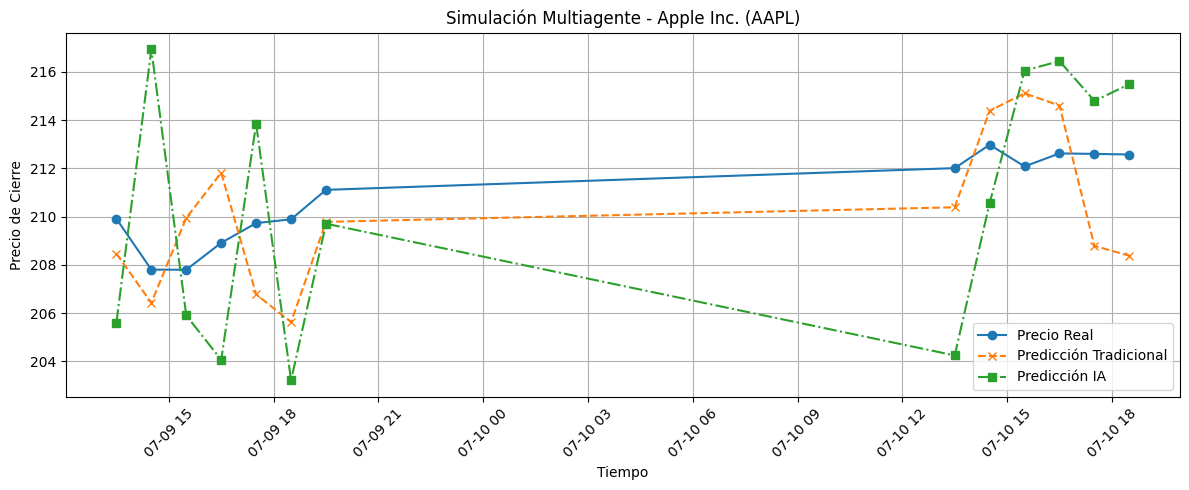

In [ ]:
# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    # Cargar datos
    df = pd.read_excel("historico_top10_indicadores_completos.xlsx")
    df = df[df['Ticker'] == 'AAPL'].reset_index(drop=True)
    env = MarketEnvironment(df)
    env.run()